In [1]:
import os
import pandas as pd
import numpy as np 
import pmdarima as pm
from pmdarima import model_selection 
from sklearn.metrics import root_mean_squared_error, mean_absolute_error 
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import datetime as dt
from sklearn.metrics import mean_squared_error
from math import sqrt


# Data managing


In [8]:
file_P = os.path.join(os.getcwd(),'Elspotprices2.csv')
df_prices = pd.read_csv(file_P)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

file_P = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.reset_index(drop=True)

# Merge the two dataframes based on HourUTC column
df_merged = pd.merge(df_prices, df_data, on="HourUTC")

# Convert HourUTC to the dataframe's index
df_merged.set_index('HourUTC', inplace=True)

# Resample the data to daily frequency, taking the mean of each day
df_daily = df_merged.select_dtypes(include=[np.number]).resample('D').mean()
# Handle NaN values before splitting the data
df_daily = df_daily.fillna(df_daily.mean())
# Add a 'Day' column representing the day number starting from the first date
df_daily['Day'] = (df_daily.index - df_daily.index[0]).days
# Split the data into training and testing sets
#train_daily, test_daily = model_selection.train_test_split(df_daily, train_size=1749)
start_train,end_train,start_test,end_test="2019-1-1","2023-11-30","2023-12-1","2023-12-31"
train_daily=df_daily[(df_daily.index >= pd.to_datetime(start_train)) & (df_daily.index <= pd.to_datetime(end_train))]
test_daily=df_daily[(df_daily.index >= pd.to_datetime(start_test)) & (df_daily.index <= pd.to_datetime(end_test))]


# plotting data

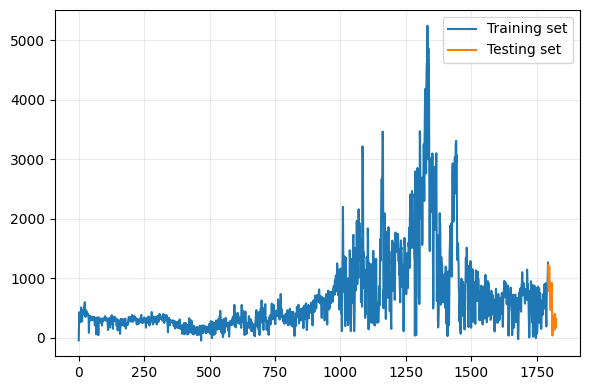

In [3]:
# Plot 'SpotPriceDKK' values against the day number
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(train_daily['Day'], train_daily["SpotPriceDKK"])
plt.plot(test_daily['Day'], test_daily["SpotPriceDKK"])
plt.legend(["Training set", "Testing set"])
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


# ACF anf PACF

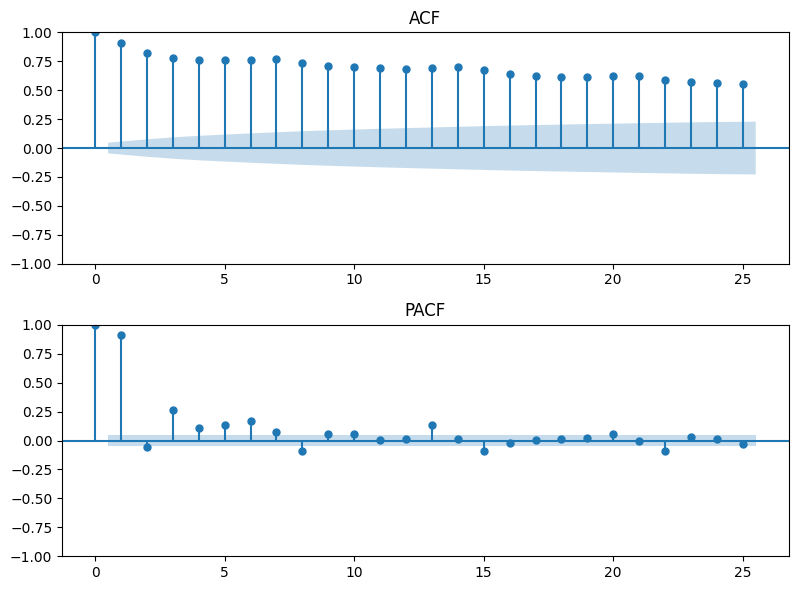

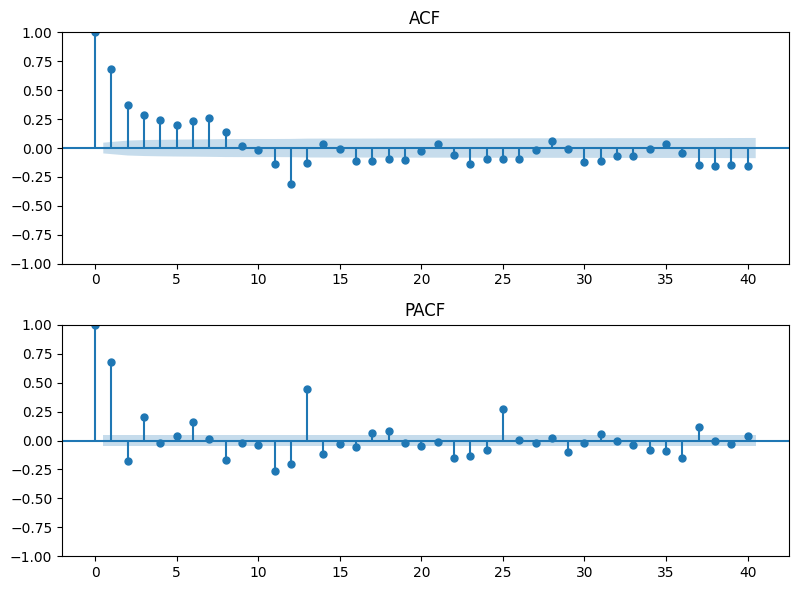

In [21]:
train_daily = train_daily.fillna(train_daily.mean())

# check for seasonality
# Plot ACF/PACF plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Check ACF plot
sm.graphics.tsa.plot_acf(train_daily["SpotPriceDKK"], title = "ACF", lags=25, ax=ax[0])

# Check the PACF plot
sm.graphics.tsa.plot_pacf(train_daily["SpotPriceDKK"], title = "PACF", lags=25, ax=ax[1])

plt.tight_layout()
plt.show()

# from the previously plot a seasonal pattern is observed, thus we will take the difference of the data with a lag of 12
train12 = train_daily.diff(12).dropna()

# Plot ACF/PACF plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Check ACF plot
sm.graphics.tsa.plot_acf(train12["SpotPriceDKK"], lags=40, title="ACF", ax=ax[0])

# Check the PACF plot
sm.graphics.tsa.plot_pacf(train12["SpotPriceDKK"], lags=40, title="PACF", ax=ax[1])

plt.tight_layout()
plt.show()

# Arima model


In [22]:
m_noS = pm.auto_arima(train_daily["SpotPriceDKK"], trace = True, seasonal = False)
m_S = pm.auto_arima(train_daily["SpotPriceDKK"], trace = True, seasonal=True, m = 12)

print(m_noS.summary())
print(m_S.summary())



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25245.976, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25536.017, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25537.827, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25537.551, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25534.028, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25247.027, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25250.238, Time=0.75 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25247.818, Time=0.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25247.163, Time=1.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25360.144, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=25246.279, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25247.948, Time=1.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=25249.313, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=25244.003, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0

# Forecasting

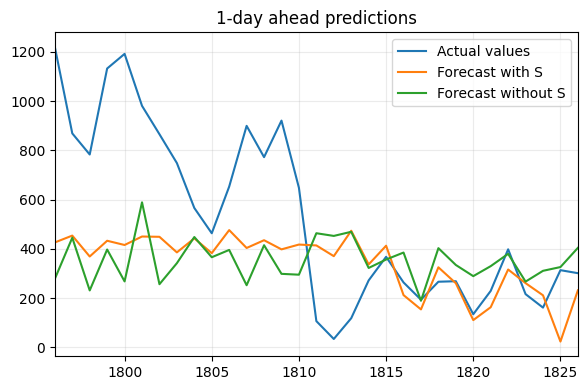

837


ValueError: x and y must have same first dimension, but have shapes (31,) and (837,)

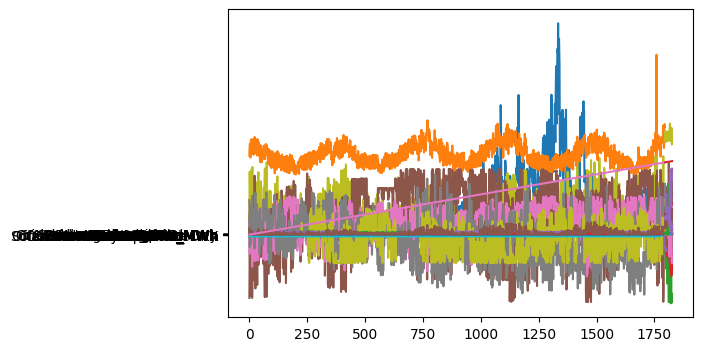

In [35]:
### 1-day predictions ###

# Create an empty list for the 1-day ahead forecasts
Forecasts_S = []
Forecasts_noS = []

for i in range(len(test_daily)):

    # Generate forecast for the next time step
    frc_S   = m_S.predict(n_periods=1)
    frc_noS = m_noS.predict(n_periods=1)
    
    # Append the forecast to the list
    Forecasts_S.extend(frc_S)
    Forecasts_noS.extend(frc_noS)
    
    # Update the model with new observations
    m_S.update(test_daily.iloc[i])
    m_noS.update(test_daily.iloc[i])

# Plot the forecasts
n_train_daily = len(train_daily)
n_data_daily = len(df_daily)  # Calculate the length of df_daily
plt.figure(figsize=(6, 4), dpi=100)
# plt.plot(np.arange(1, n_train_daily + 1), train_daily["SpotPriceDKK"])
plt.plot(np.arange(n_train_daily + 1, n_data_daily + 1), test_daily["SpotPriceDKK"])
plt.plot(np.arange(n_train_daily + 1, n_data_daily + 1), Forecasts_S)
plt.plot(np.arange(n_train_daily + 1, n_data_daily + 1), Forecasts_noS)
plt.title("1-day ahead predictions")
plt.legend(["Actual values", "Forecast with S", "Forecast without S"])
plt.xlim(n_data_daily - len(Forecasts_S) + 1, n_data_daily)
plt.tight_layout()
plt.grid(alpha=0.25)
plt.show()

# Create an empty list for the 12-month ahead peristence
N = int(len(test_daily))
Persistence12 = []

for i in range(N):
    
    Persistence12.extend(df_daily[len(train_daily)+i*1-1:len(train_daily)+(i+1)*1-1])
    
print(len(Persistence12))
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(1,n_train_daily+1), train_daily)
plt.plot(np.arange(n_train_daily+1,n_data_daily+1), test_daily)
plt.plot(np.arange(n_train_daily+1,n_data_daily+1), Forecasts_S)
plt.plot(np.arange(n_train_daily+1,n_data_daily+1), Persistence12)